In [1]:
import pyproj
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx
import shapely
from shapely.wkt import loads
from shapely.geometry import LineString, MultiLineString, Polygon, MultiPolygon, Point, box, shape
from matplotlib import pyplot as plt
import contextily as ctx
import seaborn as sns


Bad key "text.kerning_factor" on line 4 in
C:\Users\jryap\anaconda3\envs\tnc\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats, point_query
import rioxarray
import xarray
import GOSTnets as gn

In [3]:
# do not display warnings
import warnings
warnings.filterwarnings("ignore")
import json, os, sys
# add to your system path the location of the LoadOSM.py and GOSTnet.py scripts
sys.path.append(f"{os.getcwd()}/../src") #adds the GOSTNets library relative to the path of the current notebook
from toolbox_old import connect_poi

In [4]:
country_ISO = "CMR"
data_path = f"{os.getcwd()}/../data/{country_ISO}"

dirs = ["ta-lab", "results", "results/ranks-scores", "network_processing", "wb_network"]

for i in dirs:
    if not os.path.exists(f"{data_path}/{i}"):
        print(f'Successfully created new directory {data_path}/{i}')
        try:
            os.makedirs(f"{data_path}/{i}")
        except:
            continue

gadm = gpd.read_file(f"{data_path}/L2_adm/{country_ISO}_adm2.shp")
gadm = gadm.to_crs({'init':'epsg:4326'})

Successfully created new directory C:\Users\jryap\Desktop\USP\Transportation Network Criticality\notebooks/../data/CMR/ta-lab
Successfully created new directory C:\Users\jryap\Desktop\USP\Transportation Network Criticality\notebooks/../data/CMR/results
Successfully created new directory C:\Users\jryap\Desktop\USP\Transportation Network Criticality\notebooks/../data/CMR/results/ranks-scores
Successfully created new directory C:\Users\jryap\Desktop\USP\Transportation Network Criticality\notebooks/../data/CMR/network_processing


In [5]:
worldpop = rasterio.open(f"{data_path}/{country_ISO.lower()}_ppp_2020_constrained.tif")

In [6]:
population = pd.DataFrame(zonal_stats(gadm, worldpop.read(1), affine=worldpop.transform,
                                   stats='sum', nodata=worldpop.nodata)).rename(columns={'sum':'pop'})

In [7]:
# nc_filename = "GDP_per_capita_PPP_1990_2015_v2"
# rds = xarray.open_dataarray(f"{os.getcwd()}/../data/_GDPGriddedData/{nc_filename}.nc")
# rds = rds.rio.set_crs(4326)
# rds.rio.to_raster(f"{os.getcwd()}/../data/_GDPGriddedData/{nc_filename}.tif",
#                   compress="lzma", dtype="float64")

In [8]:
gdp = rasterio.open(f"{os.getcwd()}/../data/_GDPGriddedData/GDP_per_capita_PPP_1990_2015_v2.tif")
gdp = pd.DataFrame(zonal_stats(gadm, gdp.read(26),
                                       affine=gdp.transform, stats='mean',
                                       nodata=gdp.nodata)).rename(columns={"mean":"gdp"}) # as in mean GDP/capita

In [9]:
gadm = gadm.join([population, gdp])
gadm["Shape_Area"] = gadm["geometry"].area
gadm["pop_dens"] = gadm["pop"]/gadm["Shape_Area"]

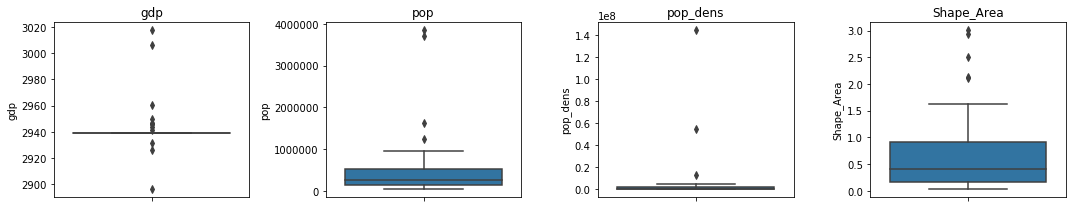

In [10]:
plots = ["gdp", "pop", "pop_dens", "Shape_Area"]
fig, ax = plt.subplots(ncols=4, figsize=(15,3))
for i in range(len(plots)):
    sns.boxplot(ax=ax[i], data=gadm, y=plots[i])
    ax[i].set_title(f"{plots[i]}")
plt.tight_layout()

__Scale population numbers to be between 0.1 and 1.01. Scaling between 0 and 1 gives rise to issues when calculating equalized OD matrix later on.__

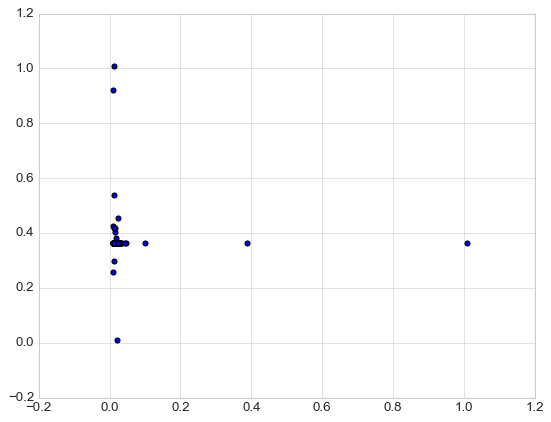

In [87]:
plt.style.use('seaborn-whitegrid')
gadm["pop_normalized"] = gadm.apply(lambda x:(0.01+(x["pop_dens"]-gadm["pop_dens"].min())/(gadm["pop_dens"].max()-gadm["pop_dens"].min())), axis=1)
gadm["gdp_normalized"] = gadm.apply(lambda x:(0.01+(x["gdp"]-gadm["gdp"].min())/(gadm["gdp"].max()-gadm["gdp"].min())), axis=1)
plt.scatter(gadm["pop_normalized"], gadm["gdp_normalized"])

In [12]:
centroids = gadm.copy()
centroids.geometry = centroids.centroid
country = gadm.dissolve(by="NAME_0") # is this needed?

In [13]:
# load edges from road_path
edges = pd.read_csv(f'{data_path}/wb_network/output/{country_ISO}_processed_edges.csv')

# ensure we have a field for each edge called 'highway'
edges.rename({'infra_type':'highway'},axis=1,inplace=True)

# make the geometry field equal to the loaded WKT shapely geometry currently stored as string in the 'geometry' field
s = edges['geometry']
l = s.apply(shapely.wkt.loads)
edges.geometry=l

# with these bit assembled, make the edges GeoDataFrame
edges = gpd.GeoDataFrame(edges)

# send the edges to a shapefile for later analysis / checking
edges.to_file(f'{data_path}/wb_network/{country_ISO}_processed_edges.shp')

In [14]:
# Here we read in the edges shapefile as a networkx object (WARNING - in future, read a gpickle - much cleaner)
graph = nx.read_shp(f'{data_path}/wb_network/{country_ISO}_processed_edges.shp')

In [15]:
# here we label up the nodes
z = 0
mapping = {}
for u, data in graph.nodes(data = True):
    data['x'] = u[0]
    data['y'] = u[1]
    mapping[u] = z
    z += 1

In [16]:
# Relabel nodes with integer value
graph = nx.relabel_nodes(graph, mapping, copy=True)

In [17]:
# Convert to MultiDigraph - add reflected edges
new_edge_bucket = []

In [18]:
# set up the integer edge ID counter field.
edge_id = 0
for u,v, data in graph.edges(data = True):
    data['edge_id'] = edge_id
    # here, I am specifying the inverse of the edge currently under consideration
    # and adding that with the same 'id' property as the current edge. So, the reflected edge will have the same ID. important!
    new_edge = (v,u, data)

    # add the new edge to the new edge bucket
    new_edge_bucket.append(new_edge)
    edge_id += 1

In [19]:
# add everything in the new edge bucket to the graph
graph.add_edges_from(new_edge_bucket)

In [20]:
# set up an edge and node GDF
graph_df = gn.edge_gdf_from_graph(graph)
node_df = gn.node_gdf_from_graph(graph)

In [21]:
%%time
sorted_graph = sorted(nx.weakly_connected_components(graph), key = len, reverse=True)

Wall time: 8 ms


In [22]:
largest_connected = graph.copy()

In [23]:
%%time
largest_connected.remove_nodes_from([n for n in largest_connected if n not in set(sorted_graph[0])])

Wall time: 92.6 ms


In [24]:
graph_df = gn.edge_gdf_from_graph(largest_connected)
node_df = gn.node_gdf_from_graph(largest_connected)

In [25]:
graph_df = graph_df[['stnode', 'endnode', 'osm_id', 'id',
       'Type', 'country', 'ShpName', 'length',
       'highway', 'edge_id', 'geometry']]
graph_df.columns=['stnode', 'x', 'endnode', 'y', 'osm_id', 'id',
       'Type', 'country', 'ShpName', 'length',
       'highway', 'edge_id', 'geometry']

In [26]:
graph_df.drop(['x', 'y'], axis=1, inplace=True)

In [27]:
connected_nodes, connected_edges = connect_poi(centroids, node_df, graph_df, key_col= "GID_2", threshold=250000)

Building rtree...
Updating external nodes...
Projecting POIs to the network...
Updating internal nodes...
Updating internal edges...
Updating external links...
Remove faulty projections: 0/58 (0.00%)
NOTE: duplication in node coordinates keys
Nodes count: 4520
Node coordinates key count: 4516
Missing 'from' nodes: 0
Missing 'to' nodes: 0


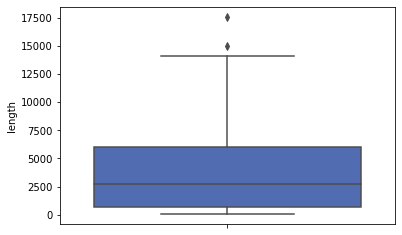

In [28]:
bp = sns.boxplot(data=connected_edges[connected_edges.highway=="projected_footway"], y="length")
plt.savefig(f'{data_path}/network_processing/{country_ISO}_projected_links.png')

In [29]:
connected_edges.to_file(f'{data_path}/network_processing/{country_ISO}_fully_connected.shp')

In [30]:
# Here we read in the edges shapefile as a networkx object (WARNING - in future, read a gpickle - much cleaner)
graph = nx.read_shp(f'{data_path}/network_processing/{country_ISO}_fully_connected.shp')

In [31]:
# here we label up the nodes
z = 0
mapping = {}
for u, data in graph.nodes(data = True):
    data['x'] = u[0]
    data['y'] = u[1]
    mapping[u] = z
    z += 1

In [32]:
# Relabel nodes with integer value
graph = nx.relabel_nodes(graph, mapping, copy=True)

In [33]:
# Convert to MultiDigraph - add reflected edges
new_edge_bucket = []

In [34]:
# set up the integer edge ID counter field.
edge_id = 0
for u,v, data in graph.edges(data = True):
    data['edge_id'] = edge_id
    # here, I am specifying the inverse of the edge currently under consideration
    # and adding that with the same 'id' property as the current edge. So, the reflected edge will have the same ID. important!
    new_edge = (v,u, data)

    # add the new edge to the new edge bucket
    new_edge_bucket.append(new_edge)
    edge_id += 1

In [35]:
# add everything in the new edge bucket to the graph
graph.add_edges_from(new_edge_bucket)

In [36]:
# Add time attribute to edges. All speeds in kmph
speed_d = {
'motorway':80,
'motorway_link': 65,
'trunk': 60,
'trunk_link':50,
'primary': 50, # kmph
'primary_link':40,
'secondary': 40, # kmph
'secondary_link':30,
'tertiary':30,
'tertiary_link': 20,
'unclassified':20,
'residential': 20,  # kmph
}

# use a GOSTNets function to add on the time factor. 'highway' is the default edge property used to assign speeds and times
graph_time = gn.convert_network_to_time(graph, distance_tag = 'length', graph_type = 'drive', speed_dict = speed_d, factor = 1000)

Change the geometry to the centroid of each admin region

In [37]:
e = centroids.copy()

In [38]:
# match these points in e onto the graph, returning the nearest node to each point.
e = gn.pandana_snap(graph_time, e)
# e = gn.pandana_snap(graph, e)
nx.write_gpickle(e, f'{data_path}/network_processing/e.gpickle')
# e = nx.read_gpickle('data/e.gpickle')

(8.114874936999998, 16.575625323, 1.0810109215000003, 13.6486468485)

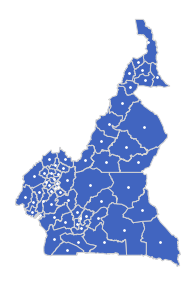

In [39]:
ax = gadm.plot(figsize=(5,5), edgecolor="lightgrey")
e.plot(ax=ax, color="white", markersize=3)
ax.axis("off")

Define mapping (district name: nearest node to district centroid).

In [40]:
district_nodes = e[["NAME_2", "NN"]]

In [41]:
district_nodes["node"] = district_nodes['NN'].apply(lambda x: 'N'+ str(x+1).zfill(5))

# For mapping areas to node ID later on
node_mapping = dict(zip(district_nodes['NAME_2'], district_nodes['node']))

# For mapping index number to district names
distr_num = dict(zip(district_nodes.index, district_nodes["NAME_2"]))

In [42]:
# here we copy and subset the smaller dataset to just the nearest node and the sum of the population in that polygon
f = e.copy()
f = f[['pop_normalized','NN']]

In [43]:
# here i do some shenanigans to get the unique origins (in terms of nodes, NOT centroids) and
# associated snapped population into list objects. Don't look to closely, it works
f['dummy'] = 1
f = f.set_index(['NN','dummy'])
f = f.sum(level = 'NN')
unique_origins = list(f.index)
pop = list(f['pop_normalized'])

In [44]:
# Here, we build the demand matrix to accompany the baseline OD matrix.
# We normalize the number of trips to 'maxtrips'
maxtrips = 100

In [45]:
# this parameter allows you to tweak the aggression of the distance decay behaviour on the demand between any two node pairs
dist_decay = 1

In [46]:
# here we define our fail value, which is returned if a journey cannot be completed between A and B
# (implies more than one subgraph or road disrupted)
fail_value = -100

In [47]:
def Calculate_OD(G, origins, destinations, fail_value, weight = 'time'):
    failed = []
    ### returns numpy O-D array for shortest travel time between each origins and destination.
    ### travel time between o and d is 'answers[o][d]'
    ### incompletable trips return the fail_value
    # G - a graph Object
    # origins - a list of nodes, by ID, that exist in G
    # destinations - a list of nodes, by ID, that exist in G
    # fail_value - must be a large int. Returned when journet between a node pair can't be completed
    # weight - we find shortest paths based on an edge weight - a property of the edges of the graph

    # make an empty numpy array to populate with the travel times
    OD = np.zeros((len(origins), len(destinations)))

    # we iterate through the origins ONLY.
    for o in range(0, len(origins)):

        # the current origin is selected using numerical indexing from the list of origin nodes
        origin = origins[o]

        # then, we calculate the shortest path from this origin to ALL potential destination nodes
        results_dict = nx.single_source_dijkstra_path_length(G, origin, cutoff = None, weight = weight)

        # from this results dictionary, we select just the nodes we need - the destination nodes.
        for d in range(0, len(destinations)):

            # select a single destination from the destinations list using numerical indexing
            destination = destinations[d]

            # populate the OD matrix with the correct result at [o][d]
            if destination in results_dict.keys():
                OD[o][d] = results_dict[destination]
            # if we can't find a destination node in the results dict, that node cannot be reached from our origin - return the fail value
            else:
                OD[o][d] = fail_value
                failed.append((o, d))

    # we return our completed, disrupted OD matrix as a numpy array
    return OD

In [48]:
# we set up a blank numpy array for the demand, same length as the origins and destinations
demand = np.zeros((len(unique_origins), len(unique_origins)))

In [49]:
# we calculate the baseline OD matrix, which has in it the travel time between node pairs assuming no disruption
# shortest_time = Calculate_OD(graph_time, unique_origins, unique_origins, fail_value)
shortest_time = Calculate_OD(graph_time, unique_origins, unique_origins, fail_value)

In [50]:
# we set up a blank numpy array for the demand, same length as the origins and destinations
demand = np.zeros((len(unique_origins), len(unique_origins)))

In [51]:
# Calculate demand between each origin and destination
for o in range(0, len(unique_origins)):
    for d in range(0, len(unique_origins)):
        if o == d:
            # do not insert demand down the spine - no trips where origin = destination
            demand[o][d] = 0
        else:
            # normalize the current travel time versus the largest travel time between nodes in the matrix
            normalized_dist = shortest_time[o][d] / shortest_time.max()

            # here, demand is a function of the product of the population of the origin and
            #  the destination - but reduced by the distance between them. 'Gravity demand'
            demand[o][d] = ((pop[o] * pop[d]) * np.exp(-1 * dist_decay * normalized_dist))

In [52]:
# we normalize the matrix to the number of maxtrips
demand = ((demand / demand.max()) * maxtrips)

# we round up - to ensure each journey is made at least once
demand = np.ceil(demand).astype(int)

In [53]:
demand_df = pd.DataFrame(demand)

In [54]:
places = e.NAME_2.tolist()
demand_df.columns = places
demand_df.index = places

In [55]:
OD_proportionality = demand_df.copy()

In [56]:
OD_equality = demand_df.copy()

for i in range(len(OD_equality)):
    for j in range(len(OD_equality)):
        if i != j:
            OD_equality.iloc[i,j] = 1

In [57]:
def equalization_all(od, variable, colname, delta):
    '''
    assumption: variable dataframe already has 'HASC_2' column
    !!!!: changed "HASC_2" to "district" for now
    '''
    
    od_ = od.copy()
    variable_ = variable.copy()
    
    variable_average = np.mean(variable_[colname]) 
    
    variable_['weight'] = variable_[colname].apply(lambda x: (x/variable_average)**-delta)

    i =0
    for val in variable_['district']:
        weight = variable_.loc[variable_['district']==val]['weight'].iloc[0]
        try:
            od_[val] *= weight 
            od_.loc[val] *= weight 
        except:
            continue
#             print(val, ' not found')
        i +=1
    
    return od_

In [58]:
popu = pd.concat([gadm["NAME_2"], gadm["pop_normalized"]],axis=1)
popu.columns = ["district", "population"]

In [59]:
gdp = pd.concat([gadm["NAME_2"], gadm["gdp_normalized"]], axis=1)
gdp.columns = ["district", "gdp"]

In [60]:
OD_equalization_GDP_05 = equalization_all(demand_df, gdp, 'gdp', 0.5)
OD_equalization_GDP_10 = equalization_all(demand_df, gdp, 'gdp', 1)
OD_equalization_GDP_20 = equalization_all(demand_df, gdp, 'gdp', 2)

In [61]:
OD_equalization_pop_05 = equalization_all(demand_df, popu, 'population', 0.5)
OD_equalization_pop_10 = equalization_all(demand_df, popu, 'population', 1)
OD_equalization_pop_20 = equalization_all(demand_df, popu, 'population', 2)

TA Lab

In [62]:
import sys
sys.path.append(f'{os.getcwd()}/../src/ta_lab')
from assignment.assign import frank_wolfe
from assignment.line import *
from assignment.graph import *
import time
from assignment.shortest_path import ShortestPath as SPP
from copy import deepcopy

In [63]:
a = gn.edge_gdf_from_graph(graph)

In [64]:
g_df = nx.to_pandas_edgelist(graph)
g_df['edge'] = g_df.index + 1
g_df['edge'] = g_df.index + 1
g_df['edge'] = g_df['edge'].apply(lambda x: 'E'+ str(x).zfill(4))
g_df = g_df[['edge', 'source', 'target', 'length', 'Wkt']]
g_df['capacity'] = 1e15

# g_df['capacity'] = capacity
g_df['alpha'] = 0.15
g_df['beta'] = 4.0
g_df['source'] = g_df['source'].apply(lambda x: 'N'+ str(x+1).zfill(5))
g_df['target'] = g_df['target'].apply(lambda x: 'N'+ str(x+1).zfill(5))
g_df.reset_index(inplace=True)

#we have to explicitly say, and assume, that each link is a two-way road
g_df2 = g_df.copy()
g_df2['source'] = g_df['target']
g_df2['target'] = g_df['source']
g_df2['edge'] = g_df2.index + 1 + len(g_df)
g_df2['edge'] = g_df2['edge'].apply(lambda x: 'E'+ str(x).zfill(4))
g_df = g_df.append(g_df2)
geoms = g_df[['edge', 'Wkt', 'index']]
g_df.drop(['Wkt', 'index'], axis=1, inplace=True)
g_df.to_csv(f"{data_path}/ta-lab/network.csv", index=False)

In [65]:
OD_matrices = [OD_equalization_GDP_05, OD_equalization_GDP_10, OD_equalization_GDP_20,
               OD_equalization_pop_05, OD_equalization_pop_10, OD_equalization_pop_20,
               OD_proportionality, OD_equality]

OD_matrices_names = ["OD_equalization_GDP_05", "OD_equalization_GDP_10", "OD_equalization_GDP_20",
                     "OD_equalization_pop_05", "OD_equalization_pop_10", "OD_equalization_pop_20",
                     "OD_proportionality", "OD_equality"]

for i in range(len(OD_matrices)):
    a = OD_matrices[i].rename(index=node_mapping, columns=node_mapping).to_dict()
    OD_matrices[i].to_csv(f'{data_path}/results/{country_ISO}_{OD_matrices_names[i]}.csv')
    
    with open(f"{data_path}/ta-lab/{OD_matrices_names[i]}.json", 'w', encoding='utf-8') as f:
        json.dump(a, f, ensure_ascii=False, indent=4)

In [66]:
nt = Network('net')
node = Vertex("a")

In [67]:
with open(f"{data_path}/ta-lab/network.csv") as fo:
    lines = fo.readlines()[1:]
    for ln in lines:
        eg = ln.split(',')
        nt.add_edge(Edge(eg))
# initialize cost
nt.init_cost()

In [68]:
dicts = []
start_time = time.time()
for i in OD_matrices_names:
    vol2 = None
    json_file_path = f"{data_path}/ta-lab/{i}.json"

    with open(json_file_path, 'r') as j:
         OD_json = json.loads(j.read())
            
    origins = list(OD_json.keys())
    destinations = list(OD_json.keys())
    
    vol2 = frank_wolfe(nt, OD_json, origins, destinations)
    dicts.append(vol2)
    
elapsed_time = time.time() - start_time
print('time of f-w: ', elapsed_time)

time of f-w:  3692.9538707733154


In [69]:
dfs = []
for i in dicts:
    vol_df = pd.DataFrame(index=i.keys(), columns=["time"])
    vol_df["time"] = i.values()
    vol_df.reset_index(inplace=True)
    vol_df.rename(columns={"index":"edge"}, inplace=True)
    vol_df = vol_df.merge(geoms, on="edge")
    vol_df["Wkt"] = vol_df["Wkt"].apply(lambda x: loads(x))
    vol_df = gpd.GeoDataFrame(vol_df, geometry="Wkt")
    vol_df.crs={'init' :'epsg:4326'}
    dfs.append(vol_df)

In [70]:
no_duplicated = geoms.drop_duplicates("index")

In [71]:
combined = dfs[0].copy()
combined.rename(columns={"time":f"time_{OD_matrices_names[0][3:]}"}, inplace=True)
for i in range(1, len(dfs)):
    combined = combined.merge(dfs[i][["edge", "time"]], on="edge").rename(columns={"time": f"time_{OD_matrices_names[i][3:]}"})
    
combined = combined[['edge', 'Wkt', 'index', 'time_equalization_GDP_05', 'time_equalization_GDP_10', 'time_equalization_GDP_20',
                     'time_equalization_pop_05', 'time_equalization_pop_10', 'time_equalization_pop_20', 'time_proportionality', 'time_equality']]

combined.to_csv(f'{data_path}/results/{country_ISO}_time_assigned.csv')

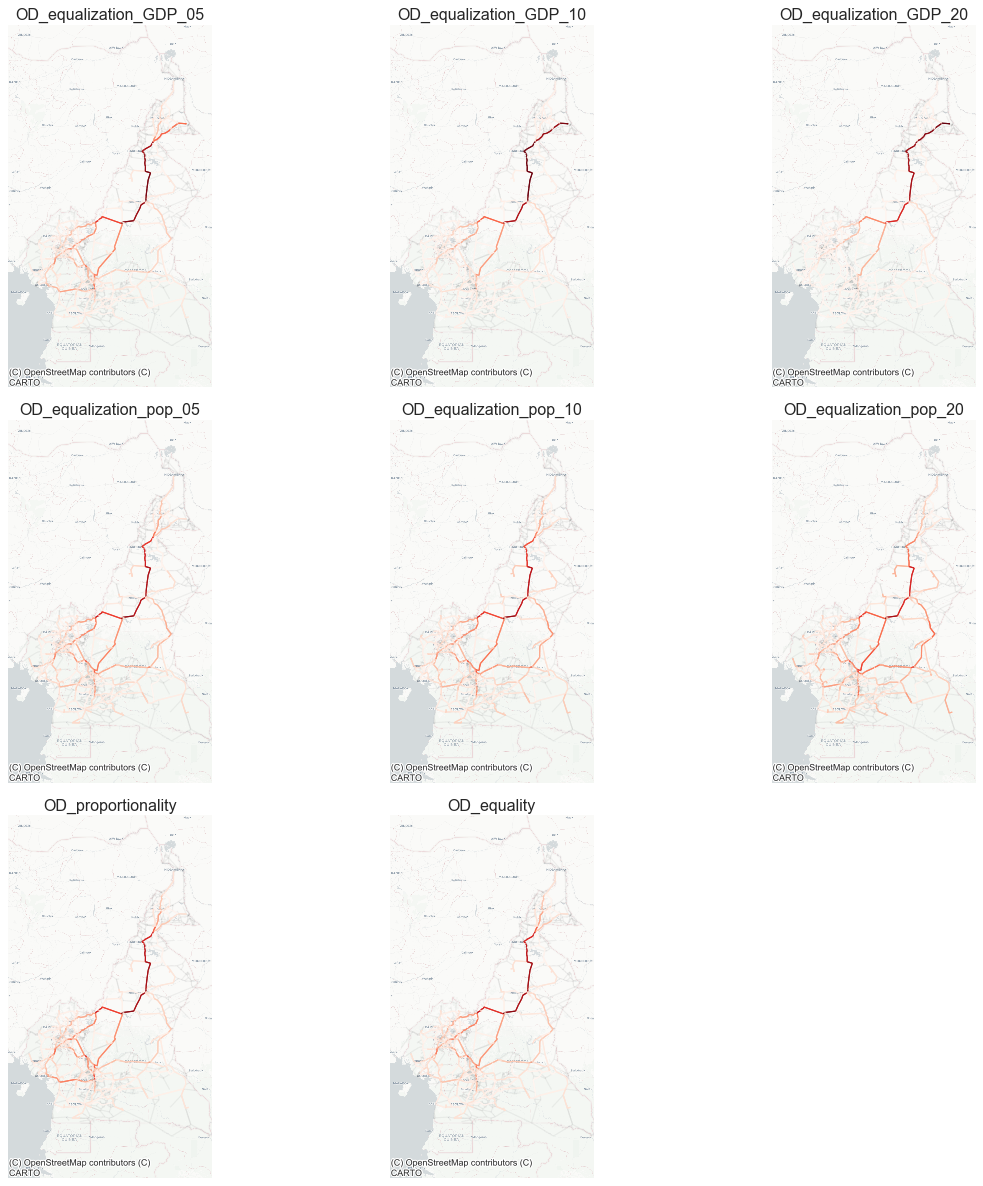

In [90]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(15,15))
k=0
for i in range(3):
    for j in range(3):
        _df = dfs[k]
        _df = _df.groupby(["index"]).agg({"time":"sum"}).reset_index()
        _df = _df.merge(no_duplicated, on="index")
        _df["Wkt"] = _df["Wkt"].apply(lambda x:loads(x))
        _df = gpd.GeoDataFrame(_df, geometry="Wkt")
        _df.crs = {'init':'epsg:4326'}
        _df[_df["time"]==0].to_crs(epsg=3857).plot(color='grey', alpha=0.05, ax=ax[i, j])
        _df[_df["time"]!=0].to_crs(epsg=3857).plot(ax=ax[i, j], column="time", cmap='Reds')
        ax[i,j].axis('off')
        ax[i,j].set_title(OD_matrices_names[k])
#         country.to_crs(epsg=3857).plot(ax=ax[i, j], alpha=0.2, color='black')
        ctx.add_basemap(ax[i, j], source=ctx.providers.CartoDB.Positron)
        _df.to_file(f"{data_path}/results/{country_ISO}_{OD_matrices_names[k]}.shp")
        k+=1
        if k == 8:
            break

fig.delaxes(ax[2, 2])
plt.tight_layout()
plt.savefig(f'{data_path}/results/{country_ISO}_combined.png')

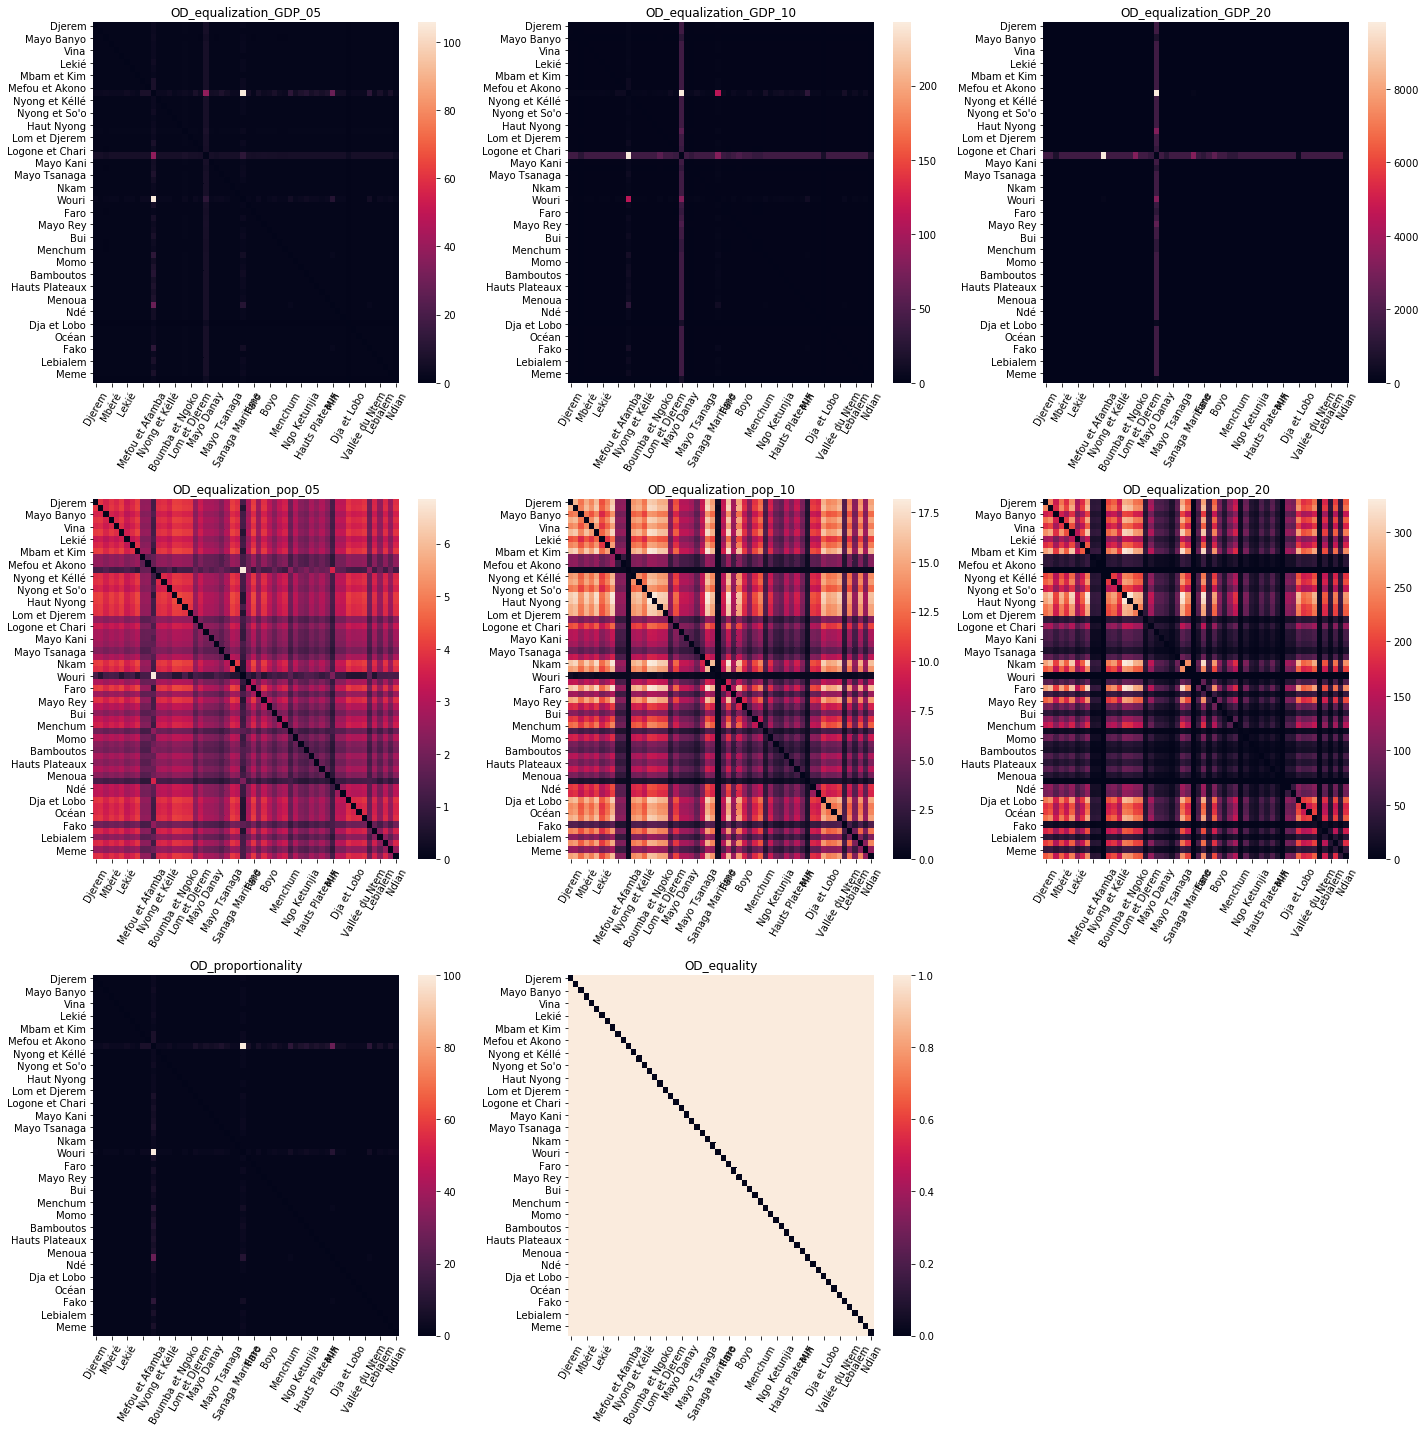

In [73]:
plt.style.use('retro')
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20,20))
k=0
for i in range(3):
    for j in range(3):
        sns.heatmap(OD_matrices[k], ax=ax[i, j])
        ax[i,j].tick_params(axis='x', labelrotation=60)
        ax[i,j].set_title(f'{OD_matrices_names[k]}')
        k+=1
        if k == 8:
            break

fig.delaxes(ax[2, 2])
plt.tight_layout()
plt.savefig(f'{data_path}/results/{country_ISO}_heatmap.png')

In [74]:
betweenness = pd.DataFrame()
for i in range(len(OD_matrices)):
    _df = pd.DataFrame(index=np.arange(len(OD_matrices[i])*len(OD_matrices[i])), columns=["location_pair", f"{OD_matrices_names[i][3:]}"])
    x=0
    for j in range(len(OD_matrices[i])):
        for k in range(len(OD_matrices[i])):
            _df.loc[x, "location_pair"] = (OD_matrices[i].index[j], OD_matrices[i].columns[k])
            _df.loc[x, f"{OD_matrices_names[i][3:]}"] = OD_matrices[i].iloc[j,k]
            x+=1
    betweenness = pd.concat([betweenness,_df],axis=1)
betweenness = betweenness.loc[:,~betweenness.columns.duplicated()]
betweenness["total"] = betweenness.apply(lambda x:sum(x[1:]), axis=1)
betweenness = betweenness.loc[betweenness['total']>0]

In [75]:
def ranking(arr):
    array = np.array(arr)
    temp = array.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))
    ranks = [len(ranks) - x for x in ranks]
    return ranks

In [76]:
cols = betweenness.columns[1:-1]

In [77]:
rank_cols=[]
for i in cols:
    betweenness[f"rank_{i}"] = ranking(betweenness[i])
    rank_cols.append(f"rank_{i}")

In [78]:
betweenness['rank_min'] = betweenness.apply(lambda row: np.min([row[rank_cols]]), axis=1)
betweenness[cols] = betweenness[cols].astype(np.float64)

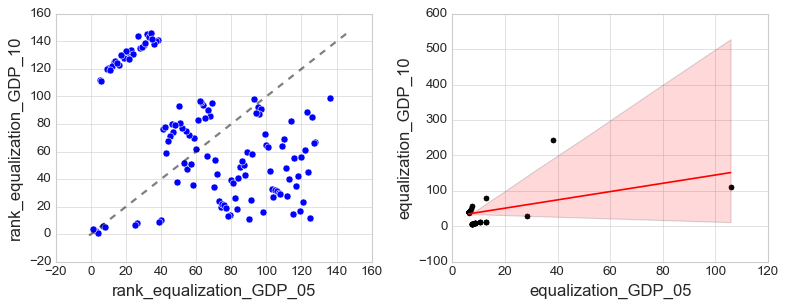

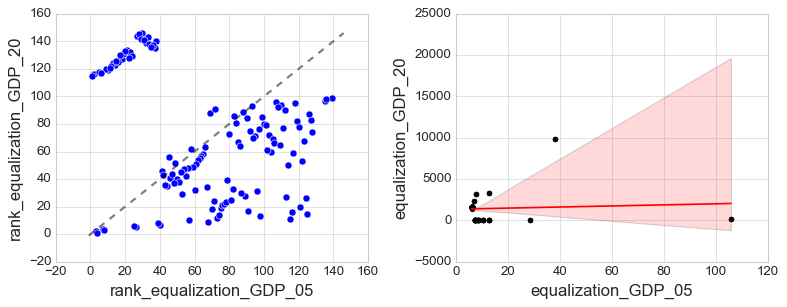

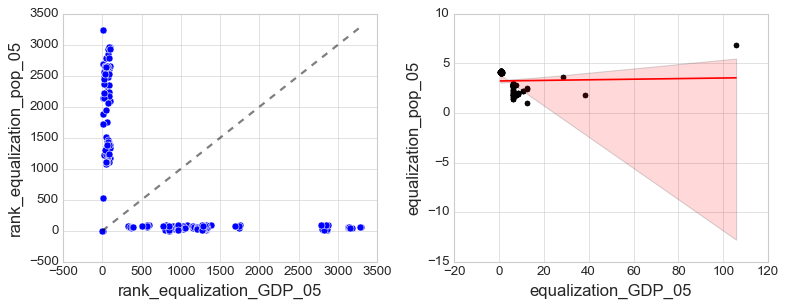

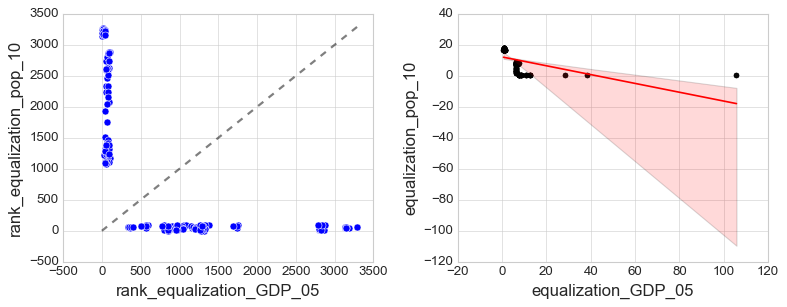

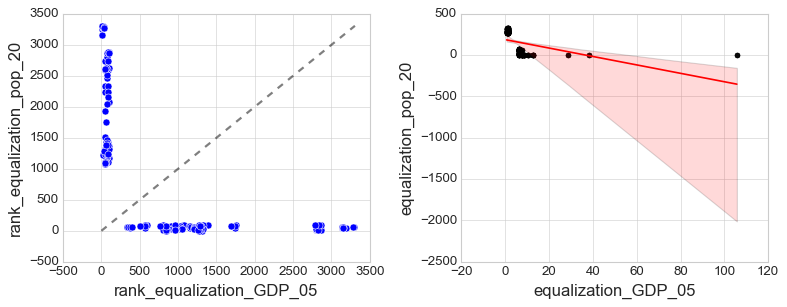

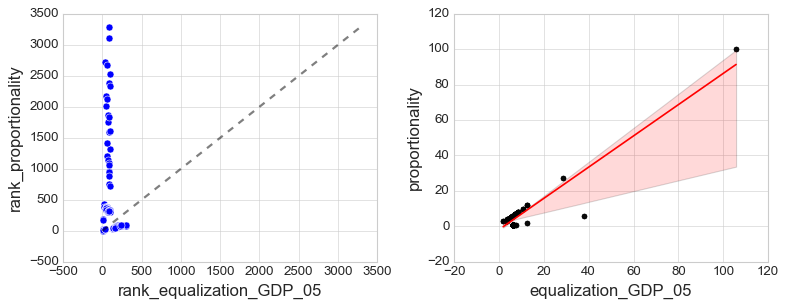

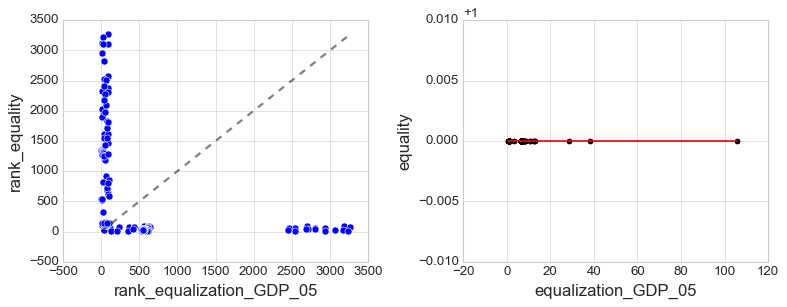

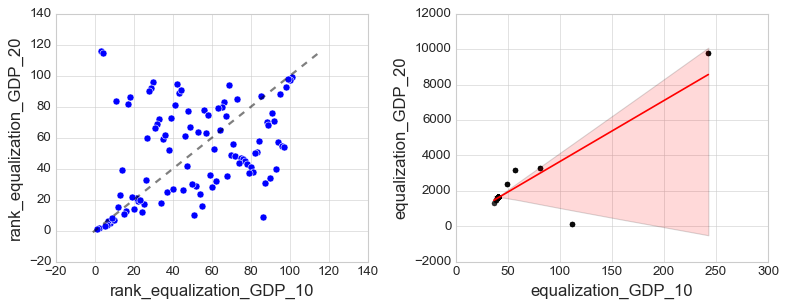

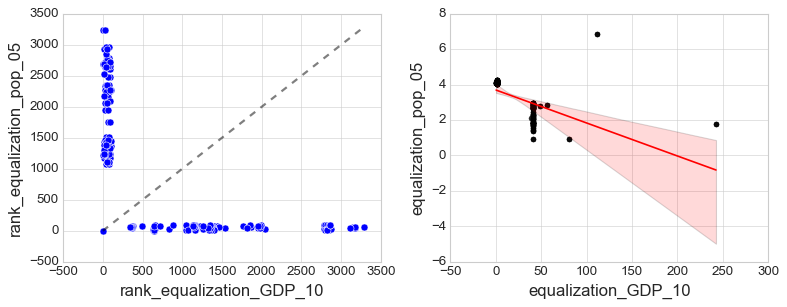

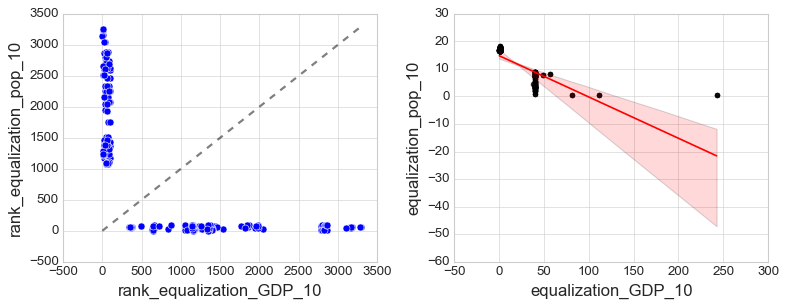

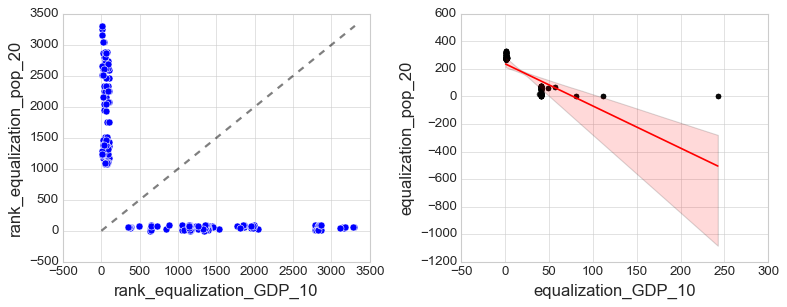

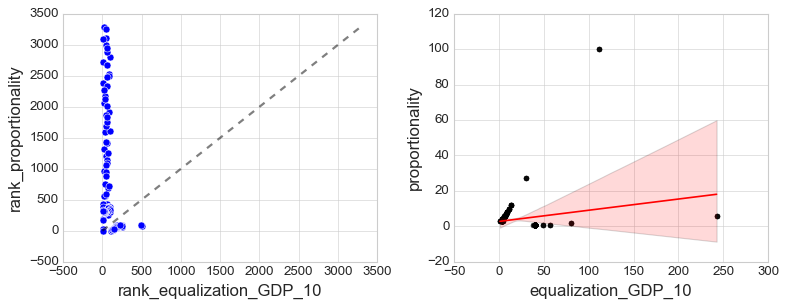

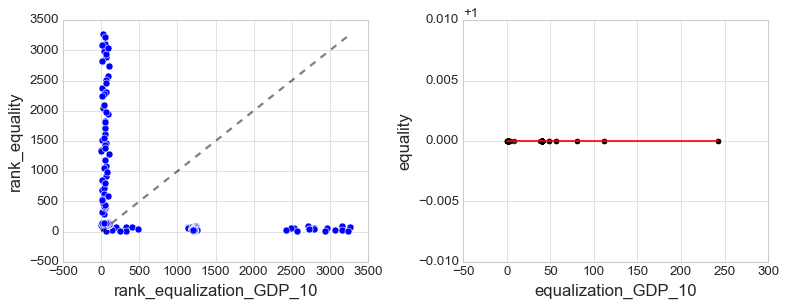

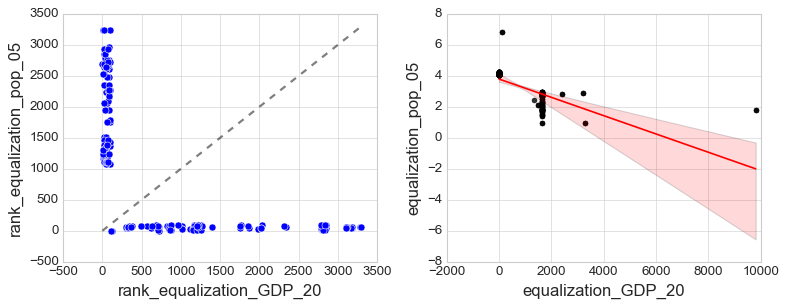

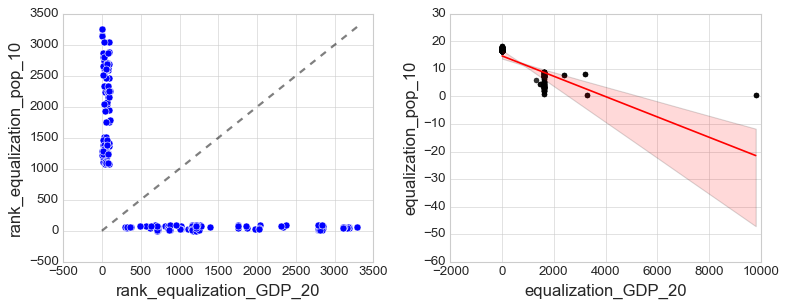

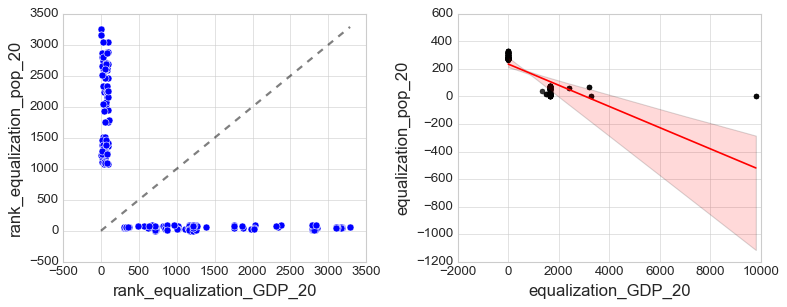

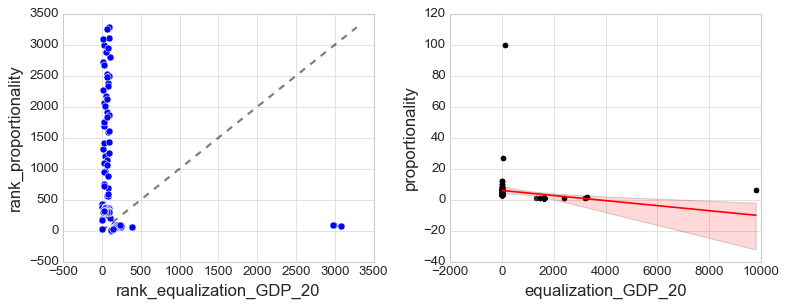

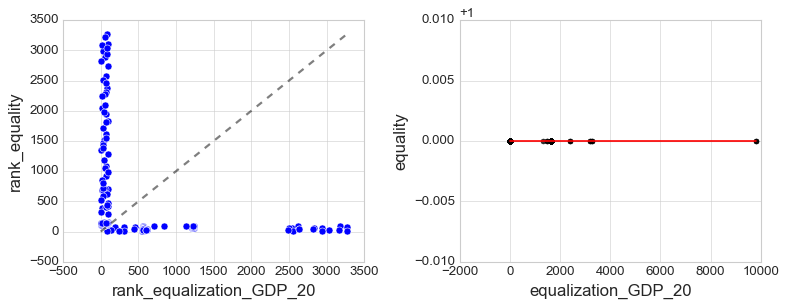

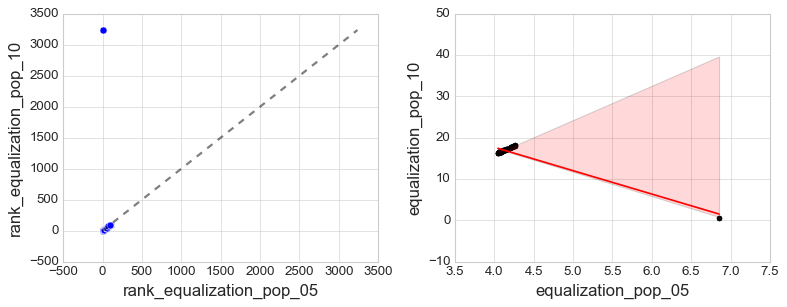

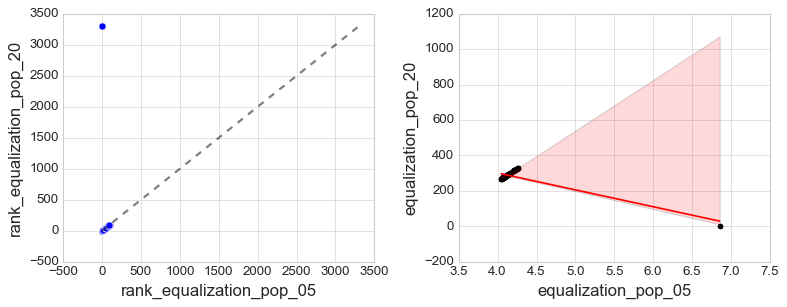

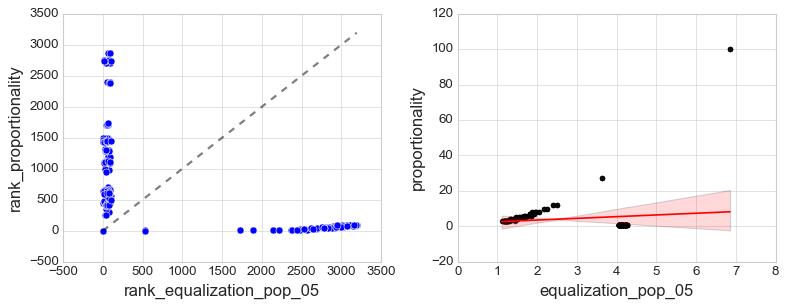

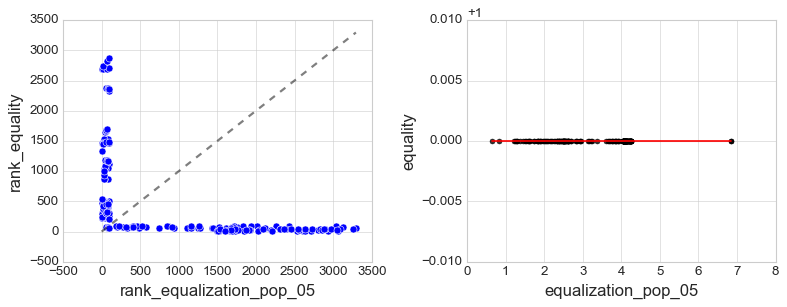

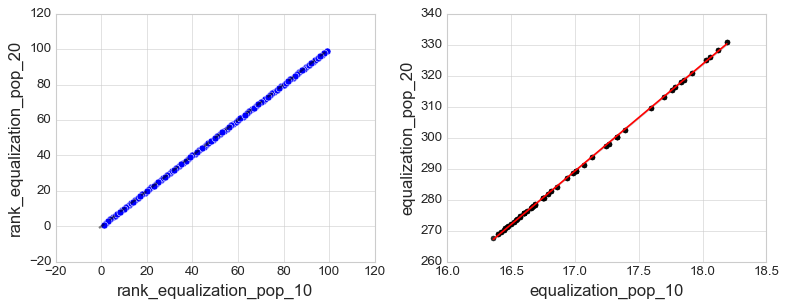

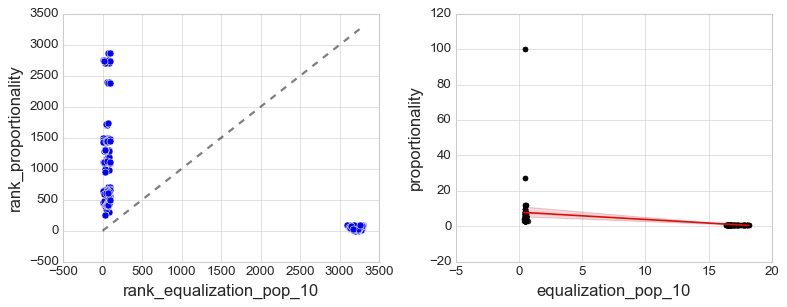

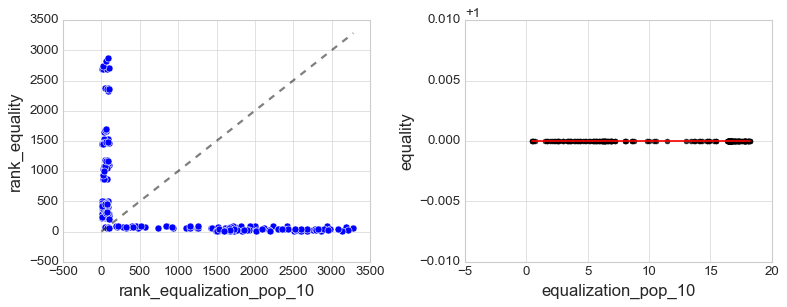

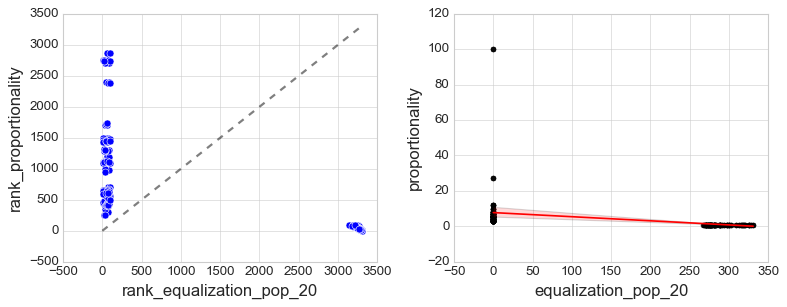

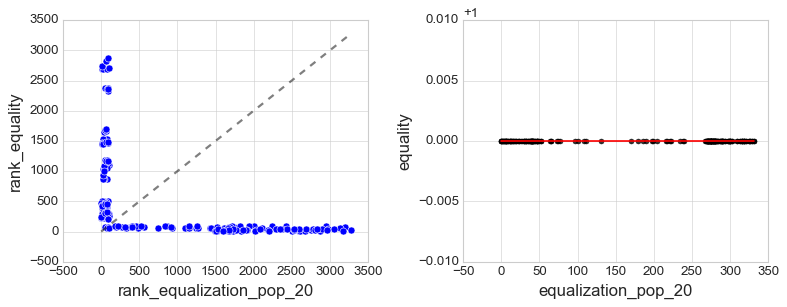

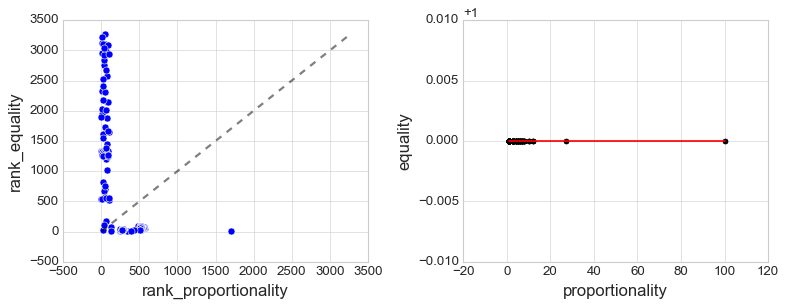

In [89]:
# all_ranks = ['rank_proportional', 'rank_equalization_1', 'rank_equalization_2', 'rank_equality'] #rank_cols
# all_principles = ['betweenness_Proportional', 'betweenness_Equalization_1', 'betweenness_Equalization_2', 'betweenness_Equality'] #cols
# OD_names = ['Proportional', 'Equalization_1', 'Equalization_2', 'Equality'] #cols
for i, rank1 in enumerate(rank_cols):
    for j, rank2 in enumerate(rank_cols):
        if rank1 != rank2 and i < j:
            betweenness['rank_min'] = betweenness.apply(lambda row: np.min([row[rank1], 
                                                                                  row[rank2]]), axis=1)
            betweenness_df2 = betweenness.loc[betweenness['rank_min']<100]
            
            max_rank1 = np.max(betweenness_df2[rank1])
            max_rank2 = np.max(betweenness_df2[rank2])
            max_rank = np.max([max_rank1, max_rank2])
            
            fig, ax = plt.subplots(ncols=2, figsize=(10,4))
            sns.scatterplot(x=rank1, y=rank2, data=betweenness_df2, s=40, ax=ax[0])
            ax[0].plot([-1,max_rank],[-1,max_rank], 'black', linewidth=2, linestyle='--', alpha=0.5)
            ax[0].yaxis.label.set_size(15)
            ax[0].xaxis.label.set_size(15)

            sns.regplot(x=cols[i], y=cols[j], data=betweenness_df2, ax=ax[1], 
                        scatter_kws={"color": "black"}, line_kws={"color": "red"})
            ax[1].yaxis.label.set_size(15)
            ax[1].xaxis.label.set_size(15)
            plt.tight_layout()
            plt.savefig(f'{data_path}/results/ranks-scores/{cols[i]}_{cols[j]}.jpeg', dpi=300, bbox_inches='tight')
            plt.show()